$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\count}[2]{\underset{#1}{\overset{#2}{\operatorname{\#}}}}
$

# Sample-by-Sample Linear Regression

Also referred to as sequential, on-line, or stochastic gradient descent, training.

Remember how we started deriving the expression for the weights that
minimized the sum of squared errors of a linear model:

With $g$ being an affine (linear + constant) function of $x$,

$$
    g(\xv;\wv) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D = \xv^T \wv
$$

having parameters $\wv = (w_0, w_1, w_2, \ldots, w_D)$, we derived the
solution to 

$$
\begin{align*}
\wv_{\mbox{best}} &= \argmin{\wv} \sum_{n=1}^N (t_n - g(\xv_n ; \wv))^2\\
 & = \argmin{\wv} \sum_{n=1}^N (t_n - \xv_n^T \wv)^2
 \end{align*}
$$

We did this by rewriting the above summation as a matrix expression,
taking its derivative with respect to $\wv$, setting the derivative
equal to zero, and solving for $\wv$.

$$
      \wv = (X^T X)^{-1} X^T T
$$

But what if you have thousands or millions of samples?  $X$ and $T$
can be quite large. To avoid dealing with matrix operations on huge
matrices, we can derive a sequential algorithm for finding $\wv$ by
using the fact that a derivative of a sum is the sum of the
derivatives.

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (t_n - \xv_n^T \wv)^2}{\partial \wv} 
&= 
\sum_{n=1}^N \frac{\partial (t_n - \xv_n^T \wv)^2}{\partial \wv}\\
&= 
\sum_{n=1}^N 2 (t_n - \xv_n^T  \wv) (-1) \xv_n\\
&= -2 \sum_{n=1}^N (t_n - \xv_n^T  \wv) \xv_n\\
\end{align*}
$$

So far this is just another way to write the matrix equation for
$\wv$.  However, instead of summing over all $N$ samples, what if we
just update $\wv$ after each sample based on the derivative of the
squared error for that sample?  The derivative for a sample $n$ can be
considered as a limited, or noisy, sample of the overall derivative.
Thus, we can take a small step in the direction of the negative derivative to try
to bring a current guess at the weight vector, $\wv^{(k)}$, on
iteration $k$ closer to a value that reduces the overall error. In general this kind of update is called "stochastic approximation".

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta (t_n - \xv_n^T  \wv) \xv_n\\
 &= \wv^{(k)} + \eta (t_n - \xv_n^T  \wv) \xv_n
\end{align*}
$$

For this sequential algorithm to converge, $\eta$ must decrease with
each iteration, not too fast but not too slow. 

This algorithm is called the least mean squares (LMS) algorithm
developed by Widrow and Hoff.  It is now often referred to as the
''stochastic gradient descent'' algorithm for linear models.

Let's animate the progress down the derivative.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This approach to animation is modeled after [this notebook](https://nbviewer.jupyter.org/github/WillClaudeHolmes/Jupyter_Examples/blob/master/AnimationIllustration.ipynb).

In [2]:
from matplotlib import animation
import matplotlib # for next statement
matplotlib.rc('animation', html='html5')
from IPython.display import display

In [3]:
nSamples = 1000
X = np.random.uniform(0,10,(nSamples,1))
T = 2 - 0.1 * X + np.random.normal(0,0.1,(nSamples,1)) + 0.0*(X-6)**2 # Change 0 to 0.05 to try to fit nonlinear cloud

X1 = np.insert(X, 0, 1, axis=1)
# T = ts.reshape((-1,1))

X1.shape, T.shape

((1000, 2), (1000, 1))

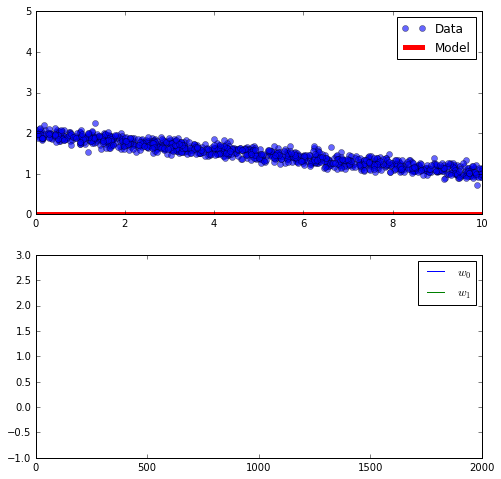

In [13]:
nIterations = 2000
w = np.zeros((2,1))
eta = 0.01

fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(X, T, 'o', alpha=0.6)
xs = np.linspace(0, 10, 100).reshape((-1,1))
xs1 = np.insert(xs, 0, 1, axis=1)
modelLine = plt.plot(xs, xs1 @ w, 'r-', linewidth=5)  # will use modelLine to update model plot
modelLine = modelLine[0]
plt.legend(('Data','Model'), loc='upper right')
plt.xlim(0, 10)
plt.ylim(0, 5)

ws = [w.copy()]

plt.subplot(2, 1, 2)
weightsLines = plt.plot(np.array(ws)[:, :, 0])  # will use to update plot of weights trajectory
plt.xlim(0, nIterations)
plt.ylim(-1, 3)
plt.legend(('$w_0$', '$w_1$'))

updatesPerFrame = 20
step = 0

def animator(framei):
    global w, step # because this function changes the value of variable w.
             # don't need to declare other variables, like ws, because they are references to objects
    for k in range(updatesPerFrame):
        n = step % nSamples
        step += 1
        predicted = X1[n:n+1,:] @ w
        # Update w using derivative of error for nth sample
        w += eta * (T[n:n+1, :] - predicted) * X1[n:n+1,:].T
        ws.append(w.copy())
    
    modelLine.set_ydata(xs1 @ w)
    wxs = range(len(ws))
    weightsLines[0].set_data( wxs, np.array(ws)[:, 0, 0])
    weightsLines[1].set_data( wxs, np.array(ws)[:, 1, 0])
        
    return modelLine, weightsLines

In [14]:
nIterations = 2000 // updatesPerFrame # integer divide
animation.FuncAnimation(fig, animator, frames=nIterations, interval=50, blit=False)